<a href="https://colab.research.google.com/github/Karishma-Kuria/DL-Graph-Neural-Networks/blob/main/GAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAT implementation

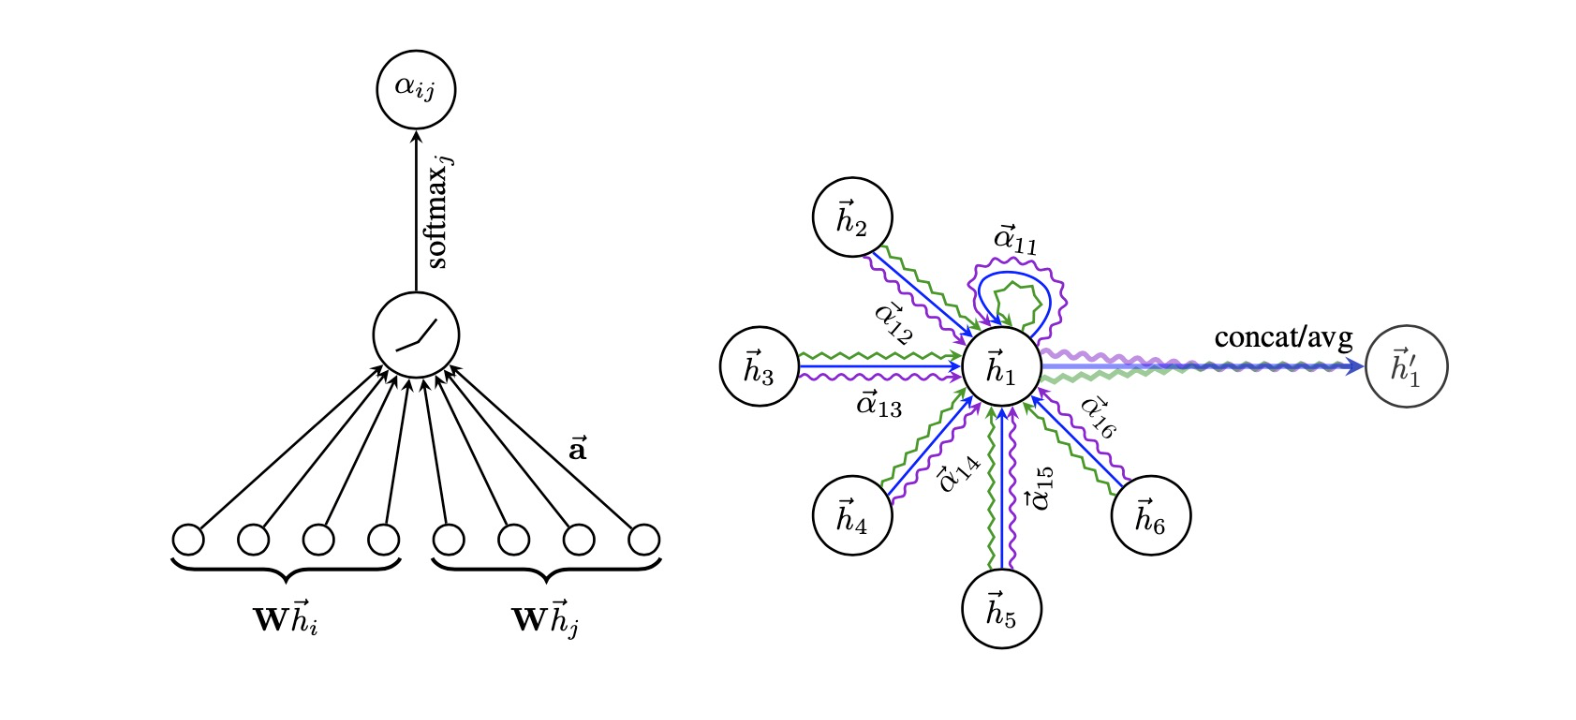

GAT (Graph Attention Network), is a novel neural network architecture that operate on graph-structured data, leveraging masked self-attentional layers to address the shortcomings of prior methods based on graph convolutions or their approximations. By stacking layers in which nodes are able to attend over their neighborhoods’ features, the method enables (implicitly) specifying different weights to different nodes in a neighborhood, without requiring any kind of costly matrix operation (such as inversion) or depending on knowing the graph structure upfront. In this way, GAT addresses several key challenges of spectral-based graph neural networks simultaneously, and make the model readily applicable to inductive as well as transductive problems.

## Outline

- Implementation of GAT

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.11.0+cu113


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

## Structure

In [ ]:
class GATLayer(nn.Module):
    """
    Simple PyTorch Implementation of the Graph Attention layer.
    """
    def __init__(self):
        super(GATLayer, self).__init__()
      
    def forward(self, input, adj):
        print("")

## Let's start from the forward method

### Linear Transformation

$$
\bar{h'}_i = \textbf{W}\cdot \bar{h}_i
$$
with $\textbf{W}\in\mathbb R^{F'\times F}$ and $\bar{h}_i\in\mathbb R^{F}$.

$$
\bar{h'}_i \in \mathbb{R}^{F'}
$$

In [ ]:
in_features = 5
out_features = 2
nb_nodes = 3

W = nn.Parameter(torch.zeros(size=(in_features, out_features))) #xavier paramiter inizializator
nn.init.xavier_uniform_(W.data, gain=1.414)

input = torch.rand(nb_nodes,in_features) 


# linear transformation
h = torch.mm(input, W)
N = h.size()[0]

print(h.shape)

torch.Size([3, 2])


### Attention Mechanism

![title](AttentionMechanism.png)

In [ ]:
a = nn.Parameter(torch.zeros(size=(2*out_features, 1))) #xavier paramiter inizializator
nn.init.xavier_uniform_(a.data, gain=1.414)
print(a.shape)

leakyrelu = nn.LeakyReLU(0.2)  # LeakyReLU

torch.Size([4, 1])


In [ ]:
a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * out_features)

![title](a_input.png)

In [ ]:
e = leakyrelu(torch.matmul(a_input, a).squeeze(2))

In [ ]:
print(a_input.shape,a.shape)
print("")
print(torch.matmul(a_input,a).shape)
print("")
print(torch.matmul(a_input,a).squeeze(2).shape)

torch.Size([3, 3, 4]) torch.Size([4, 1])

torch.Size([3, 3, 1])

torch.Size([3, 3])


### Masked Attention

In [ ]:
# Masked Attention
adj = torch.randint(2, (3, 3))

zero_vec  = -9e15*torch.ones_like(e)
print(zero_vec.shape)

torch.Size([3, 3])


In [ ]:
attention = torch.where(adj > 0, e, zero_vec)
print(adj,"\n",e,"\n",zero_vec)
attention

tensor([[1, 1, 0],
        [1, 0, 1],
        [1, 0, 0]]) 
 tensor([[ 0.3525, -0.0464,  0.1233],
        [ 0.8030,  0.2184,  0.5737],
        [ 1.2552,  0.6707,  1.0260]], grad_fn=<LeakyReluBackward0>) 
 tensor([[-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15]])


tensor([[ 3.5255e-01, -4.6397e-02, -9.0000e+15],
        [ 8.0297e-01, -9.0000e+15,  5.7374e-01],
        [ 1.2552e+00, -9.0000e+15, -9.0000e+15]], grad_fn=<SWhereBackward0>)

In [ ]:
attention = F.softmax(attention, dim=1)
h_prime   = torch.matmul(attention, h)

In [ ]:
attention

tensor([[0.5984, 0.4016, 0.0000],
        [0.5571, 0.0000, 0.4429],
        [1.0000, 0.0000, 0.0000]], grad_fn=<SoftmaxBackward0>)

In [ ]:
h_prime

tensor([[ 0.3447, -0.6885],
        [ 0.7855, -0.5135],
        [ 0.4173, -0.5125]], grad_fn=<MmBackward0>)

#### h_prime vs h

In [ ]:
print(h_prime,"\n",h)

tensor([[ 0.3447, -0.6885],
        [ 0.7855, -0.5135],
        [ 0.4173, -0.5125]], grad_fn=<MmBackward0>) 
 tensor([[ 0.4173, -0.5125],
        [ 0.2364, -0.9508],
        [ 1.2486, -0.5147]], grad_fn=<MmBackward0>)


# Build the layer

In [ ]:
class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GATLayer, self).__init__()
        
        '''
        TODO
        '''
        
    def forward(self, input, adj):
        # Linear Transformation
        h = torch.mm(input, self.W) # matrix multiplication
        N = h.size()[0]

        # Attention Mechanism
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e       = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        # Masked Attention
        zero_vec  = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime   = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

In [ ]:
class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GATLayer, self).__init__()
        self.dropout       = dropout        # drop prob = 0.6
        self.in_features   = in_features    # 
        self.out_features  = out_features   # 
        self.alpha         = alpha          # LeakyReLU with negative input slope, alpha = 0.2
        self.concat        = concat         # conacat = True for all layers except the output layer.

        
        # Xavier Initialization of Weights
        # Alternatively use weights_init to apply weights of choice 
        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        
        self.a = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        
        # LeakyReLU
        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj):
        # Linear Transformation
        h = torch.mm(input, self.W) # matrix multiplication
        N = h.size()[0]
        print(N)

        # Attention Mechanism
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e       = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        # Masked Attention
        zero_vec  = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime   = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

# Use it

In [ ]:
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

import matplotlib.pyplot as plt

name_data = 'Cora'
dataset = Planetoid(root= '/tmp/' + name_data, name = name_data)
dataset.transform = T.NormalizeFeatures()

print(f"Number of Classes in {name_data}:", dataset.num_classes)
print(f"Number of Node Features in {name_data}:", dataset.num_node_features)

Number of Classes in Cora: 7
Number of Node Features in Cora: 1433


In [ ]:
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1
        
        
        self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.6)
        self.conv2 = GATConv(self.hid*self.in_head, dataset.num_classes, concat=False,
                             heads=self.out_head, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
                
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)
    
    
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

model = GAT().to(device)
data = dataset[0].to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

model.train()
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    
    if epoch%200 == 0:
        print(loss)
    
    loss.backward()
    optimizer.step()
    
    

tensor(1.9426, grad_fn=<NllLossBackward0>)
tensor(0.7334, grad_fn=<NllLossBackward0>)
tensor(0.6343, grad_fn=<NllLossBackward0>)
tensor(0.4937, grad_fn=<NllLossBackward0>)
tensor(0.6484, grad_fn=<NllLossBackward0>)


In [ ]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.8270


# **Implementing GAT Layer in PyTorch**

## **Imports**

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(2020) # seed for reproducible numbers

## **GAT Layer**

In [ ]:
class GATLayer(nn.Module):
    """
    Simple PyTorch Implementation of the Graph Attention layer.
    """

    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GATLayer, self).__init__()
        self.dropout       = dropout        # drop prob = 0.6
        self.in_features   = in_features    # 
        self.out_features  = out_features   # 
        self.alpha         = alpha          # LeakyReLU with negative input slope, alpha = 0.2
        self.concat        = concat         # conacat = True for all layers except the output layer.

        # Xavier Initialization of Weights
        # Alternatively use weights_init to apply weights of choice 
        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        
        # LeakyReLU
        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj):
        # Linear Transformation
        h = torch.mm(input, self.W)
        N = h.size()[0]

        # Attention Mechanism
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e       = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        # Masked Attention
        zero_vec  = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime   = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

# **Implementing GAT on Citation Datasets using PyTorch Geometric**

## **PyG Imports**

In [ ]:
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

import matplotlib.pyplot as plt
%matplotlib notebook

import warnings
warnings.filterwarnings("ignore")
name_data = 'Cora'
dataset = Planetoid(root= '/tmp/' + name_data, name = name_data)
dataset.transform = T.NormalizeFeatures()

print(f"Number of Classes in {name_data}:", dataset.num_classes)
print(f"Number of Node Features in {name_data}:", dataset.num_node_features)


Number of Classes in Cora: 7
Number of Node Features in Cora: 1433


## **Model**

In [ ]:
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1
        
        self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.6)
        self.conv2 = GATConv(self.hid*self.in_head, dataset.num_classes, concat=False,
                             heads=self.out_head, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Dropout before the GAT layer is used to avoid overfitting in small datasets like Cora.
        # One can skip them if the dataset is sufficiently large.
        
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

## **Train**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GAT().to(device)

data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

model.train()
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    
    if epoch%200 == 0:
        print(loss)
    
    loss.backward()
    optimizer.step()

tensor(1.9431, grad_fn=<NllLossBackward0>)
tensor(0.7300, grad_fn=<NllLossBackward0>)
tensor(0.5585, grad_fn=<NllLossBackward0>)
tensor(0.5857, grad_fn=<NllLossBackward0>)
tensor(0.5164, grad_fn=<NllLossBackward0>)


## **Evaluate**

In [ ]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.8280
